In [160]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
pd.options.mode.chained_assignment = None 

%matplotlib inline


#The data is contained in 4 .csv files
gdp = pd.read_csv("data/datasets_15310_20369_gdp_improvement_rate.csv")
literacy = pd.read_csv("data/datasets_15310_20369_literacy_rate.csv")
unemployment = pd.read_csv("data/datasets_15310_20369_unemployment.csv")
youth = pd.read_csv("data/datasets_15310_20369_youth.csv")

#drop columns that are empty
literacy.drop(['86.3', '90', '82.7', '7.3\t'], inplace = True, axis = 1)


#merge all data frames together
gl = gdp.merge(literacy, on='country', how = 'outer')
glu = gl.merge(unemployment, on='country', how = 'outer')
df = glu.merge(youth, on='country', how = 'outer')

#fix column names that contain spaces
cols = []
for col in list(df.columns):
    col = col.replace(" ", "")
    cols.append(col)
df.columns = cols

df.head()

,country,growth_rate,literacy_rate_percent_all,male_literacy_percent_rate,female_literacy_percent_rate,gender_difference_percentWorld,unemployment_percentage,youth_percentage
0,Bangladesh,13.438,61.5,64.6,58.5,6.1,4.1,28.3
1,Ethiopia,8.464,49.1,57.2,41.1,16.1,17.5,43.7
2,China,6.800,96.4,98.2,94.5,3.7,4.0,17.1
3,Ivory Coast Cote d'Ivoire,7.632,NaN,NaN,NaN,NaN,NaN,NaN
4,Nepal,7.499,64.7,75.6,55.1,20.5,3.3,30.9


In [161]:
#find the percent of data that is present in each column
(df.shape[0] - df.isnull().sum())/df.shape[0] * 100

country                           100.000000
growth_rate                        68.817204
literacy_rate_percent_all          54.121864
male_literacy_percent_rate         54.121864
female_literacy_percent_rate       54.121864
gender_difference_percentWorld     54.121864
unemployment_percentage            78.853047
youth_percentage                   82.795699
dtype: float64

In [162]:
#the most data is missing in the literacy and gender difference columns

#get total df size
df.shape

(279, 8)

In [163]:
#Is this the same as the number of **unique** values in the country column?
df['country'].nunique()

276

In [164]:
#Let's remove rows where there are duplicate country names
df.drop_duplicates(subset='country', keep="first", inplace = True)
df.shape

(276, 8)

In [165]:
#how many values are *present* in the "unemployment_percentage" column
df.shape[0] - df['unemployment_percentage'].isnull().sum()

217

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

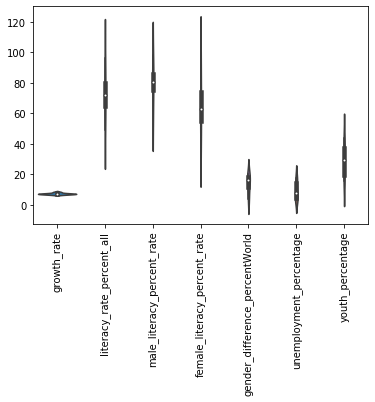

In [166]:
#That's a lot of missing data. Let's see how the data are distributed.
sns.violinplot(data=df[1:8])
plt.xticks(rotation=90)

/Users/egill/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/egill/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


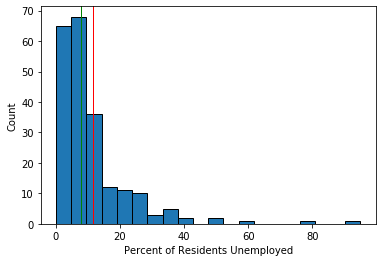

In [167]:
#I'd like to get a better look at the distribution of the unemployment data
plt.hist(df['unemployment_percentage'], bins=20, edgecolor="black")
plt.xlabel('Percent of Residents Unemployed')
plt.ylabel('Count')
#let's plot the data mean with a red line
plt.axvline(df['unemployment_percentage'].mean(), color="red", linewidth = 1)
#and the data median with a green line
plt.axvline(df['unemployment_percentage'].median(), color="green", linewidth = 1)

In [168]:
#Looks like the data have a right-skewed distribution. Most countries have a relatively low rate of unemployment,
#but some countries are particularly hard-hit.

#Let's investigate which factors in our data frame are correlated with unemployment.

#First we'll have to clean the data.
df.head()

,country,growth_rate,literacy_rate_percent_all,male_literacy_percent_rate,female_literacy_percent_rate,gender_difference_percentWorld,unemployment_percentage,youth_percentage
0,Bangladesh,13.438,61.5,64.6,58.5,6.1,4.1,28.3
1,Ethiopia,8.464,49.1,57.2,41.1,16.1,17.5,43.7
2,China,6.800,96.4,98.2,94.5,3.7,4.0,17.1
3,Ivory Coast Cote d'Ivoire,7.632,NaN,NaN,NaN,NaN,NaN,NaN
4,Nepal,7.499,64.7,75.6,55.1,20.5,3.3,30.9


In [169]:
def clean_data(df):
    # Drop rows with missing unemployment values, country name
    df.dropna(subset=['unemployment_percentage'], axis=0, inplace = True)

    y = df['unemployment_percentage']
    
    df1 = df.drop(['country', 'unemployment_percentage'], axis = 1)
    
    # Fill numeric columns with the mean
    num_vars = df1.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df1[col].fillna((df1[col].mean()), inplace=True)
        
    X = df1
    return X, y
    
#Use the function to create X and y
X, y = clean_data(df)  


In [170]:
#let's check whether everything worked as expected
print(X.shape)
print(y.shape)

(217, 6)
(217,)


In [171]:
#Looks like we have all 217 rows that contain names of countries. 
#Sanity check to make sure all NaNs in X have been filled
(X.shape[0] - X.isnull().sum())/X.shape[0] * 100

growth_rate                       100.0
literacy_rate_percent_all         100.0
male_literacy_percent_rate        100.0
female_literacy_percent_rate      100.0
gender_difference_percentWorld    100.0
youth_percentage                  100.0
dtype: float64

In [172]:
#Now we'll fit a linear model
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=3) 


lm_model = LinearRegression(normalize=True) 
lm_model.fit(X_train, y_train)
    
y_train_preds = lm_model.predict(X_train)
train_score = (r2_score(y_train, y_train_preds))
    
y_test_preds = lm_model.predict(X_test) 
test_score = (r2_score(y_test, y_test_preds))
 

print(test_score, train_score)

0.09722067090039954 0.08758428784855143


In [173]:
#It looks like only about 9% of the variation we're seeing in the unemployment rates
#can be explained by the factors that we're examining here.

#Let's look at what the most influential variables are
def coef_weights(coefficients, X_train):

    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df

,est_int,coefs,abs_coefs
3,female_literacy_percent_rate,14.678218,14.678218
4,gender_difference_percentWorld,12.286586,12.286586
2,male_literacy_percent_rate,-9.638249,9.638249
1,literacy_rate_percent_all,-4.945861,4.945861
0,growth_rate,-0.595563,0.595563
5,youth_percentage,0.381763,0.381763


Text(0, 0.5, 'Percent of Residents Unemployed')

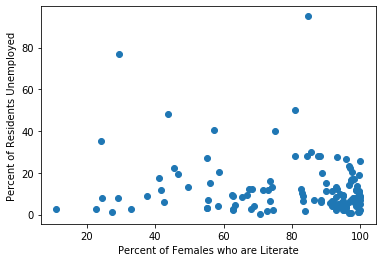

In [177]:
#It looks like percent of the female popluation of a country that is literate has the largest 
#effect on unemployment, followed by the percent gender difference.

#First, let's plot female literacy against unemployment to explore this relationship further
plt.scatter(df['female_literacy_percent_rate'], df['unemployment_percentage'])
plt.xlabel('Percent of Females who are Literate')
plt.ylabel('Percent of Residents Unemployed')

Text(0, 0.5, 'Percent of Residents Unemployed')

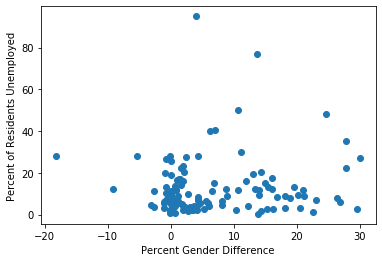

In [178]:
plt.scatter(df['gender_difference_percentWorld'], df['unemployment_percentage'])
plt.xlabel('Percent Gender Difference')
plt.ylabel('Percent of Residents Unemployed')

Text(0, 0.5, 'Percent of Residents Unemployed')

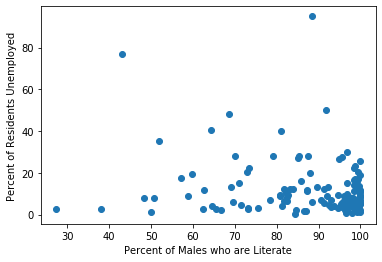

In [179]:
plt.scatter(df['male_literacy_percent_rate'], df['unemployment_percentage'])
plt.xlabel('Percent of Males who are Literate')
plt.ylabel('Percent of Residents Unemployed')